# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [35]:
data_train.head()

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,0,199042938,Caucasian,Male,[50-60),?,3.0,1.0,1,1,...,A+,14.5,False,None,None,No,No,No,Yes,No
1,1,91962954,Caucasian,Male,[80-90),?,2.0,1.0,7,3,...,B+,15.7,False,None,>7,No,No,No,No,Yes
2,2,109707084,EURO,Female,[60-70),?,1.0,1.0,7,5,...,O+,13.0,False,NONE,None,No,Yes,Ch,Yes,No
3,3,157495374,Black,Female,[70-80),?,6.0,1.0,17,2,...,AB-,13.5,False,NONE,>8,No,No,No,Yes,No
4,4,82692360,Caucasian,Female,NaN,?,1.0,22.0,7,12,...,A+,13.0,False,None,None,No,No,No,No,No


In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

In [5]:
def assign_categorical(df, column_list: []):
    _df = df.copy()
    for column in column_list:
        _df[column] = _df[column].astype('category')
    return _df

In [6]:
def encode_unordered_categorical(df, column_list: []):
    _df = df.copy()
    ohe = ce.OneHotEncoder(verbose=1,
                           cols=column_list,
                           handle_missing="indicator",
                           use_cat_names=True)
    _df = ohe.fit_transform(_df)
    return _df

In [7]:
def encode_ordinal_categorical(df, column_list: []):
    _df = df.copy()
    orde = ce.OrdinalEncoder(verbose=1,
                             cols=column_list,
                             handle_unknown='value',
                             handle_missing='value')
    _df = orde.fit_transform(_df)
    return _df

In [8]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df[target]

In [9]:
target = 'readmitted'

index_col = 'admission_id'

all_features = ['patient_id',
                'race',
                'gender',
                'age',
                'weight',                
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'time_in_hospital', 
                'payer_code',
                'medical_specialty',
                'has_prosthesis',
                'complete_vaccination_status',
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'diag_1',
                'diag_2',
                'diag_3',
                'number_diagnoses',
                'blood_type',
                'hemoglobin_level',
                'blood_transfusion',
                'max_glu_serum',
                'A1Cresult',
                'diuretics',
                'insulin',
                'change',
                'diabetesMed']

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'complete_vaccination_status',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type',
                'max_glu_serum',
                'A1Cresult']

ord_cat_features = ['age',
                    'weight']

# missing features: date of admission and date of release

In [10]:
#ProfileReport(data_train)

In [11]:
# Assigning categorical variables, but no encoding yet
testdf = assign_categorical(data_train, (cat_features + ord_cat_features + bool_features))

# Convert target to boolean
testdf['readmitted'] = build_target(testdf, 'readmitted')

In [12]:
testdf.head()

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,0,199042938,Caucasian,Male,[50-60),?,3.0,1.0,1,1,...,A+,14.5,False,None,None,No,No,No,Yes,False
1,1,91962954,Caucasian,Male,[80-90),?,2.0,1.0,7,3,...,B+,15.7,False,None,>7,No,No,No,No,True
2,2,109707084,EURO,Female,[60-70),?,1.0,1.0,7,5,...,O+,13.0,False,NONE,None,No,Yes,Ch,Yes,False
3,3,157495374,Black,Female,[70-80),?,6.0,1.0,17,2,...,AB-,13.5,False,NONE,>8,No,No,No,Yes,False
4,4,82692360,Caucasian,Female,NaN,?,1.0,22.0,7,12,...,A+,13.0,False,None,None,No,No,No,No,False


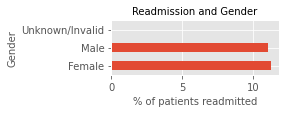

In [13]:
data = testdf.pivot_table(values=['readmitted'], index='gender', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 1]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Gender", size=10)
plt.title("Readmission and Gender", size=10);

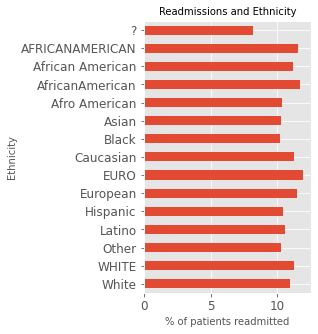

In [14]:
data = testdf.pivot_table(values=['readmitted'], index='race', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 15/3]
data.plot.barh(stacked=True, legend=None).invert_yaxis();
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Ethnicity", size=10)
plt.title("Readmissions and Ethnicity", size=10);

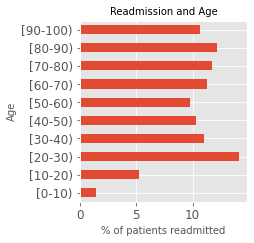

In [15]:
data = testdf.pivot_table(values=['readmitted'], index='age', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 10/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Age", size=10)
plt.title("Readmission and Age", size=10);

In [16]:
testdf.payer_code.nunique()

18

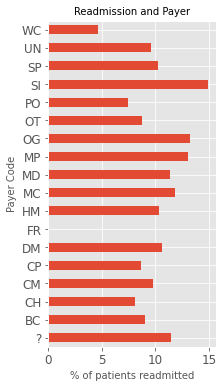

In [17]:
data = testdf.pivot_table(values=['readmitted'], index='payer_code', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 18/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Payer Code", size=10)
plt.title("Readmission and Payer", size=10);

In [18]:
specialty_summary = testdf.pivot_table(values=['readmitted'],
                                       index='medical_specialty',
                                       aggfunc=('count','mean'))
specialty_summary = (specialty_summary[specialty_summary['readmitted']['count']>100].
                     droplevel(0, axis=1)
                    .rename(columns={'mean': '% readmitted'})
                    .sort_values(by='% readmitted', ascending=False))

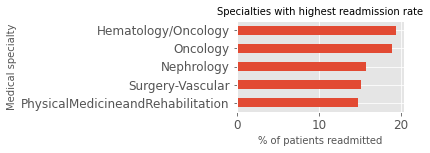

In [19]:
data = specialty_summary.drop('count', axis=1).head(5)*100
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None).invert_yaxis();
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Medical specialty", size=10)
plt.title("Specialties with highest readmission rate", size=10);

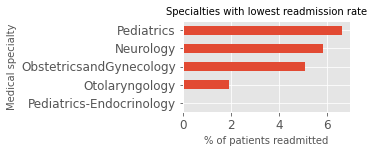

In [20]:
data = specialty_summary.drop('count', axis=1).tail(5)*100
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None).invert_yaxis();
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Medical specialty", size=10)
plt.title("Specialties with lowest readmission rate", size=10);

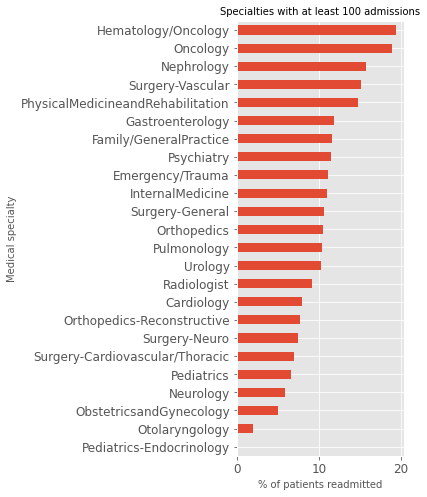

In [21]:
data = (specialty_summary.drop('count', axis=1)
        .drop('?', axis=0))*100
plt.rcParams["figure.figsize"] = [3, 24/3]
data.plot.barh(stacked=True, legend=None).invert_yaxis();
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Medical specialty", size=10)
plt.title("Specialties with at least 100 admissions", size=10);

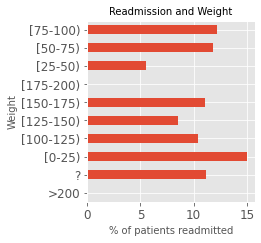

In [22]:
data = testdf.pivot_table(values=['readmitted'], index='weight', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 10/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Weight", size=10)
plt.title("Readmission and Weight", size=10);

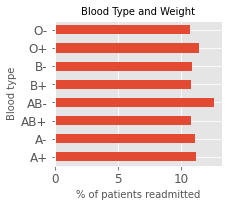

In [23]:
data = testdf.pivot_table(values=['readmitted'], index='blood_type', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 8/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Blood type", size=10)
plt.title("Blood Type and Weight", size=10);

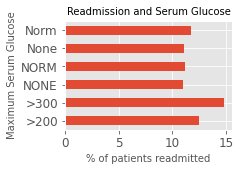

In [24]:
data = testdf.pivot_table(values=['readmitted'], index='max_glu_serum', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 6/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Maximum Serum Glucose", size=10)
plt.title("Readmission and Serum Glucose", size=10);

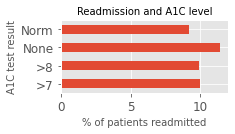

In [25]:
data = testdf.pivot_table(values=['readmitted'], index='A1Cresult', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 4/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("A1C test result", size=10)
plt.title("Readmission and A1C level", size=10);

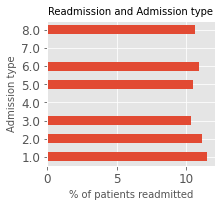

In [26]:
data = testdf.pivot_table(values=['readmitted'], index='admission_type_code', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 8/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Admission type", size=10)
plt.title("Readmission and Admission type", size=10);

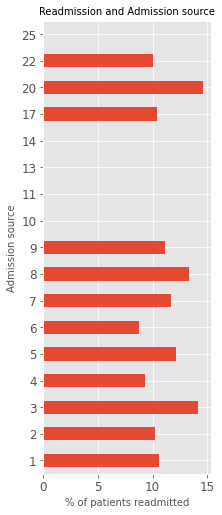

In [27]:
data = testdf.pivot_table(values=['readmitted'], index='admission_source_code', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 25/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Admission source", size=10)
plt.title("Readmission and Admission source", size=10);

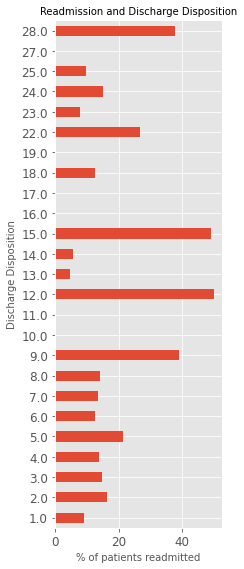

In [28]:
data = testdf.pivot_table(values=['readmitted'], index='discharge_disposition_code', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 28/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("% of patients readmitted", size=10)
plt.ylabel("Discharge Disposition", size=10)
plt.title("Readmission and Discharge Disposition", size=10);

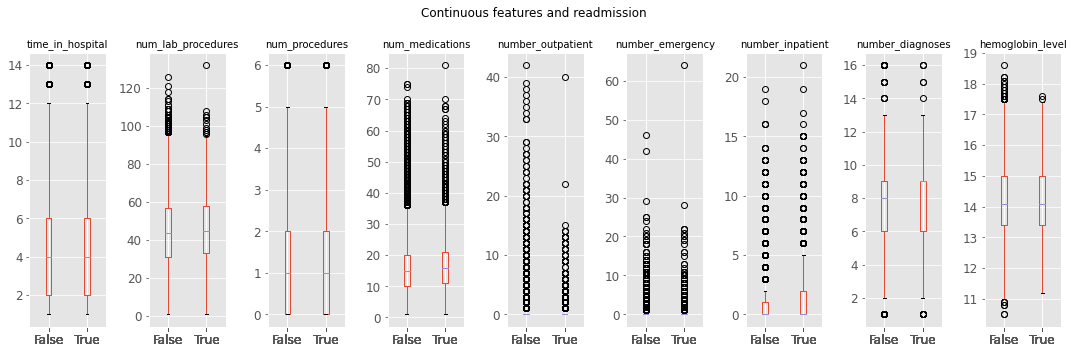

In [34]:
fig, axes = plt.subplots(1,len(num_features), sharex=True) # create figure and axes
plt.rcParams["figure.figsize"] = [15, 5]
for i, ax in enumerate(axes.flat):
    testdf.boxplot(column=num_features[i], by="readmitted", ax=axes.flatten()[i])
    ax.set_title(str(num_features[i]), fontsize=10)
    ax.xaxis.label.set_visible(False)
fig.suptitle("Continuous features and readmission", size=12)
plt.xlabel("% of patients readmitted", size=10)
plt.tight_layout() 
plt.show();

IndexError: list index out of range

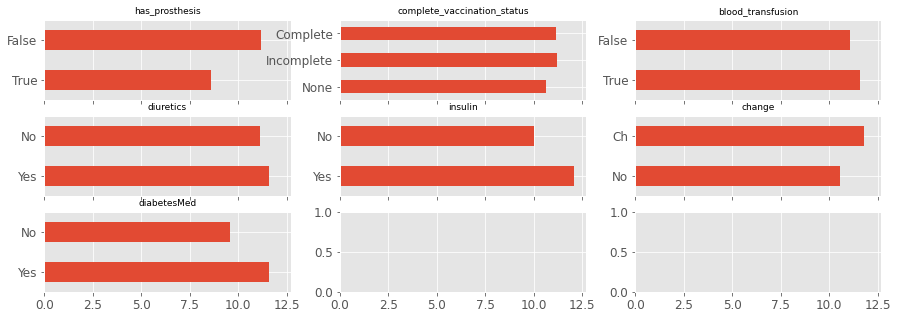

In [30]:
fig, axes = plt.subplots(3,3, sharex=True) # create figure and axes
plt.rcParams["figure.figsize"] = [9.33, 4]
for i, ax in enumerate(axes.flat):
    data = testdf.pivot_table(values=['readmitted'], index=bool_features[i], aggfunc=np.mean)*100
    data.plot.barh(stacked=True, legend=None, ax=axes.flatten()[i]).invert_yaxis()
    ax.set_title(str(bool_features[i]), fontsize=9)
    ax.yaxis.label.set_visible(False)
fig.suptitle("Boolean features and readmission", size=10)
plt.xlabel("% of patients readmitted", size=10)
plt.show();